# Hierarchical Risk Parity

En este notebook vamos a implementar el Hierarchical Risk Parity (HRP) de Marcos López de Prado (https://doi.org/10.3905/jpm.2016.42.4.059) y luego discutiremos no solo el por qué del procedimiento, sino también las posibles alternativas con lo que hemos visto hasta ahora de clustering.

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [156]:
lista_activos = ['A', 'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'ADM', 'ADSK',
                 'AMAT', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AON', 'APA', 'APD',
                 'CAT', 'CB', 'CBRE', 'CCI', 'CCL', 'CF', 'CHRW', 'CI', 'CINF',
                 'COP', 'COST', 'CPB', 'CRM', 'CSCO', 'CTAS', 'CTRA', 'CTSH',
                 'DIS', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'EA', 'EBAY',
                 'FSLR', 'GD', 'GE', 'GEN', 'GILD', 'GIS', 'GL', 'GLW', 'GM', 'GOOG',
                 'GOOGL', 'GPC', 'GS', 'GWW', 'HAL', 'HAS', 'HBAN', 'HD', 'HES', 'HIG',
                 'LOW', 'LRCX', 'LUV', 'LYB', 'MA', 'MAS', 'MCD', 'MCHP', 'MCK', 'MCO',
                 'MDT', 'MET', 'META', 'MHK', 'MKC', 'MLM', 'MMC', 'MMM', 'MO', 'MOS',
                 'NFLX', 'NI', 'NKE', 'NOC', 'NRG', 'NSC', 'NTAP', 'NTRS', 'NUE',
                 'NVDA', 'NWL', 'NWSA', 'OKE', 'OMC', 'ORCL', 'ORLY', 'OXY', 'PARA',
                 'SYK', 'SYY', 'T', 'TAP', 'TEL', 'TFC', 'TGT', 'TJX', 'TMO', 'TPR',
                 'XRAY', 'XYL', 'YUM', 'ZBH', 'ZION', 'ZTS']

## Descarga y preprocesamiento de datos

In [157]:
datos = yf.download(lista_activos, start="2020-01-01")["Adj Close"]
datos.head()

[*********************100%%**********************]  117 of 117 completed


Ticker,A,AAPL,ABBV,ABT,ACN,ADBE,ADM,ADSK,AMAT,AME,...,TGT,TJX,TMO,TPR,XRAY,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,83.502029,73.059418,73.511116,80.490288,196.918243,334.429993,41.377090,187.830002,59.723305,97.938499,...,114.780769,58.389492,323.139648,24.367493,54.089363,75.849648,94.470116,140.247589,45.190216,129.823151
2020-01-03,82.161339,72.349144,72.813354,79.509033,196.590240,331.809998,41.296310,184.949997,58.772732,98.074539,...,113.588066,57.954170,319.624817,24.358442,53.490784,76.296097,94.174217,139.880981,44.552517,129.842484
2020-01-06,82.404213,72.925636,73.387970,79.925621,195.306473,333.709991,40.973270,187.119995,57.505283,98.181412,...,112.513748,58.323246,321.921844,24.666092,53.785328,75.802147,94.118759,139.072586,44.009613,128.845627
2020-01-07,82.656822,72.582664,72.969307,79.481270,191.089813,333.390015,40.479721,187.500000,59.166405,98.744965,...,112.714035,58.285393,323.743683,24.901350,54.070351,75.517174,94.285194,138.950378,43.742470,129.281158
2020-01-08,83.472878,73.750252,73.486481,79.805267,191.464661,337.869995,40.031052,189.949997,59.127998,98.968422,...,112.349854,58.597683,324.258545,25.064224,54.640423,75.773636,94.451607,140.614182,44.173344,129.000519


In [158]:
retornos = np.log(datos).diff().dropna()
retornos.head()

Ticker,A,AAPL,ABBV,ABT,ACN,ADBE,ADM,ADSK,AMAT,AME,...,TGT,TJX,TMO,TPR,XRAY,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.016186,-0.009769,-0.009537,-0.012266,-0.001667,-0.007865,-0.001954,-0.015452,-0.016044,0.001388,...,-0.010446,-0.007483,-0.010937,-0.000371,-0.011128,0.005869,-0.003137,-0.002617,-0.014212,0.000149
2020-01-06,0.002952,0.007937,0.007861,0.005226,-0.006552,0.005710,-0.007853,0.011665,-0.021801,0.001089,...,-0.009503,0.006348,0.007161,0.012551,0.005491,-0.006495,-0.000589,-0.005796,-0.012261,-0.007707
2020-01-07,0.003061,-0.004714,-0.005721,-0.005575,-0.021826,-0.000959,-0.012119,0.002029,0.028477,0.005724,...,0.001779,-0.000649,0.005643,0.009493,0.005285,-0.003767,0.001767,-0.000879,-0.006089,0.003375
2020-01-08,0.009824,0.015958,0.007063,0.004068,0.001960,0.013348,-0.011146,0.012982,-0.000649,0.002260,...,-0.003236,0.005344,0.001589,0.006519,0.010488,0.003390,0.001763,0.011903,0.009802,-0.002173
2020-01-09,0.015590,0.021018,0.007678,0.002664,0.008868,0.007607,-0.010365,0.010422,0.006313,-0.004921,...,0.000810,0.011561,0.006422,-0.011620,0.000695,0.004503,0.007898,-0.006640,0.006611,0.013192


## Tree Clustering

La primera fase es donde aplicamos la fase de clusterización a partir de la matriz de correlación $\rho$. La matriz de correlación es una herramienta muy útil en el análisis de riesgos y la construcción de carteras. Nos permite comprender cómo los activos individuales se relacionan entre sí.

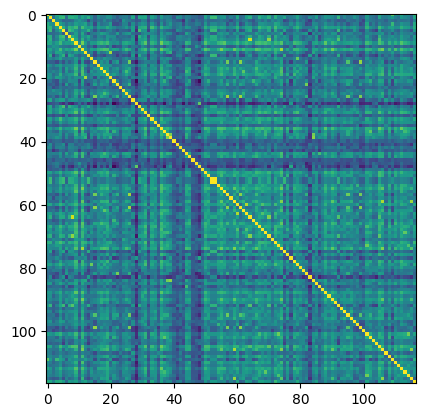

In [159]:
matriz_corr = retornos.corr()
plt.imshow(matriz_corr)
plt.show()

Parece razonable, una vez disponemos de la matriz de correlación, hacer clustering para encontrar aquellos activos que más se parecen entre sí.

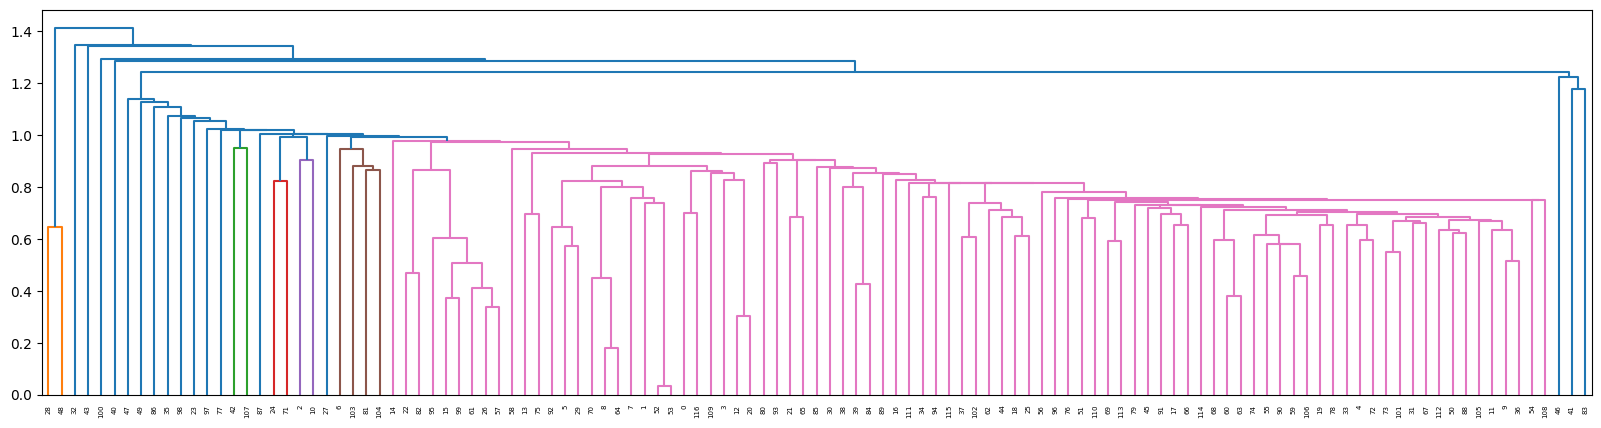

In [160]:
Z = linkage(matriz_corr, "single", "euclidean")
plt.figure(figsize=(20, 5))
dendrogram(Z)
plt.show()

Sin embargo, López de Prado propone no hacer clustering directamente con la matriz de correlación, sino con la siguiente transformación:

$$d_{i,j} = \sqrt{\frac{1}{2} (1 - \rho_{i,j})}$$

De esta forma, define un espacio de medida apropiado respecto a que:

- Cualquier distancia $d_{i,j}$ es siempre positiva: $d_{i,j} \geq 0$

- Todas las distancias cumplen la desigualdad triangular: $d_{a,c} \leq d_{a,b} + d_{a,c}$

In [161]:
matriz_dist = np.sqrt(0.5 * (1 - matriz_corr))
print(matriz_dist.shape)

(117, 117)


<ipython-input-162-332205e87cd5>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(matriz_dist, "single", "euclidean")


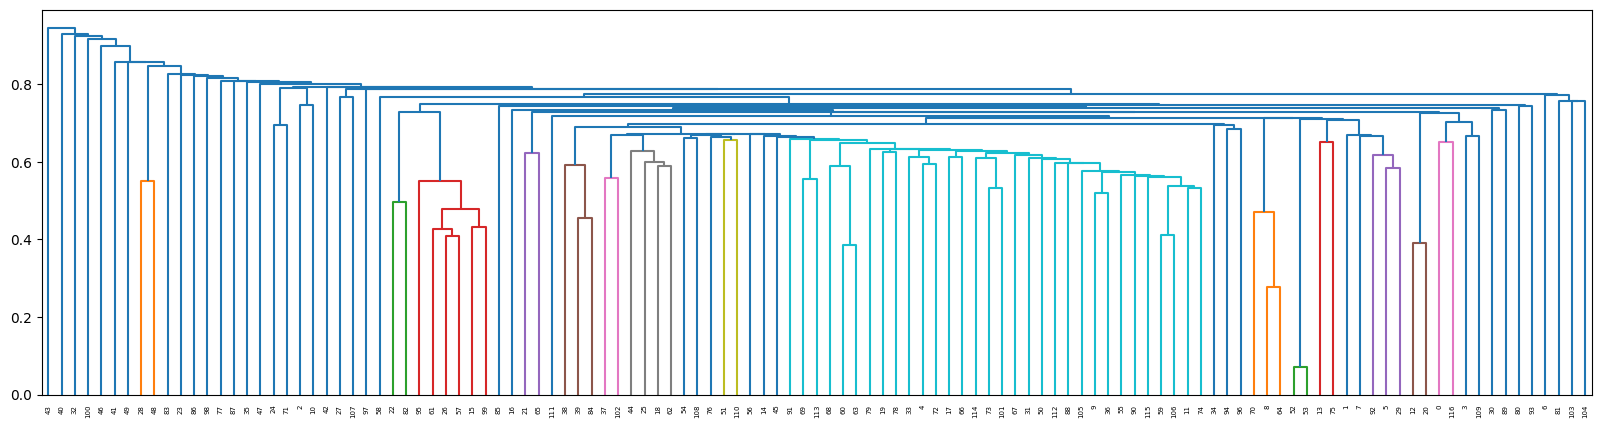

In [162]:
Z = linkage(matriz_dist, "single", "euclidean")
plt.figure(figsize=(20, 5))
dendrogram(Z)
plt.show()

## Quasi-Diagonalization

Una vez se dispone del dendrograma, el proceso de quasi-diagonalización consigue redistribuir los activos para que aquellos activos similares se agrupen en la matriz de correlación.

Lopez de Prado propone utilizar el dendrograma de una forma particular, sabiendo que cada lincado une dos ramas en una sola. El algoritmo consiste en reemplazar constantemente el cluster más distante, es decir, el último que se ha formado, por sus componentes, hasta que no quede ningún cluster.

Para seguir el algoritmo propuesto, debemos entender qué información tiene nuestro linkage.

<img src="https://raw.githubusercontent.com/christianolivamoya/MIAX12-ML/main/images/ejemplo_risk_parity.jpeg">

En este ejemplo, Z contendría la siguiente información (la ? indica distancia, que es irrelevante):

<table>
  <tr>
    <td>2</td>
    <td>4</td>
    <td>?</td>
    <td>2</td>
  </tr>
  <tr>
    <td>0</td>
    <td>5</td>
    <td>?</td>
    <td>2</td>
  </tr>
  <tr>
    <td>3</td>
    <td>6</td>
    <td>?</td>
    <td>3</td>
  </tr>
  <tr>
    <td>8</td>
    <td>1</td>
    <td>?</td>
    <td>4</td>
  </tr>
  <tr>
    <td>7</td>
    <td>9</td>
    <td>?</td>
    <td>6</td>
  </tr>
</table>


De la tabla sabemos lo siguiente:

- `tabla[-1, 3] = 6` contiene el número de elementos del linkage.
- Si restamos a una posición el número de elementos `6`, sabemos el índice de las dos ramas que lo componen. Por ejemplo:

$\quad$ 7 - 6 = 1 $\rightarrow$ `tabla[1] = [0 5]`

Es decir, la rama 7, que se ha formado en la posición 1, está compuesta por los elementos 0 y 5.

In [163]:
def getQuasiDiag(link):
    # Nos aseguramos de que sean enteros
    link = link.astype(int)

    # Sabemos que cada fila del linkado Z une dos ramas en una.
    # Desde el último elemento hacia arriba, reemplazamos el cluster por sus dos componentes
    # Estos reemplazos mantienen el orden del clustering
    # El output del algoritmo es la lista ordenada de los activos

    # 1) Cogemos el último elemento del linkage como punto de partida
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])

    # 2) Cogemos el número de elementos del cluster, es decir, el número de activos
    numItems = link[-1, 3]

    # 3) Mientras que uno de los componentes sea un cluster, es decir, mientras que su
    #    ID sea mayor que el número de activos, aplicamos el algoritmo
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)
        df0 = sortIx[sortIx >= numItems]
        i = df0.index
        j = df0.values - numItems

        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)

        sortIx = pd.concat([sortIx, df0])  # item 2
        sortIx = sortIx.sort_index()  # re-sort

        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

In [164]:
order = getQuasiDiag(Z)
cluster_members = np.array(retornos.columns)[order]

Compara el resultado de la siguiente celda, que muestra en la imagen izquierda la matriz de correlación tal cual, frente a la imagen derecha que muestra la matriz de correlación ordenada según el árbol generado.

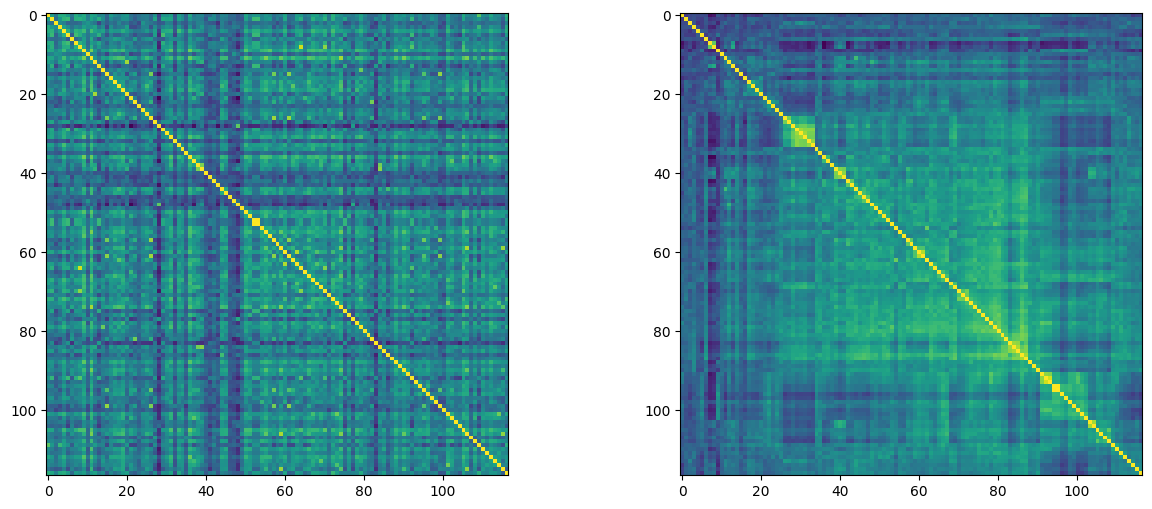

In [165]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.imshow(matriz_corr)
plt.subplot(1,2,2)
plt.imshow(matriz_corr.loc[cluster_members, cluster_members])
plt.show()

## Recursive Bisection

La última fase consiste en asignar pesos a cada activo para optimizar la cartera.

La función divide de manera recursiva el conjunto de activos en clusters más pequeños hasta que cada cluster contiene un solo activo. Durante la división, se ajustan los pesos de los activos dentro de cada cluster según la varianza de cada cluster, asignando más peso a los activos en clusters con menor varianza y menos peso a los activos en clusters con mayor varianza.

In [166]:
def getIVP(cov):
  ivp = 1.0 / np.diag(cov)
  ivp /= ivp.sum()
  return ivp

def getClusterVar(cov, items):
  cov_ = cov.loc[items, items]  # matrix slice
  w_ = getIVP(cov_).reshape(-1, 1)
  cVar = np.dot(np.dot(w_.T, cov_), w_)[0, 0]
  return cVar

def getRecBipart(cov, sortIx):
    w = pd.Series(1, index=sortIx)  # Se inicializan los pesos
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        # cItems = [
        #     i[int(j) : int(k)]
        #     for i in cItems
        #     for j, k in ((0, len(i) / 2), (len(i) / 2, len(i)))
        #     if len(i) > 1
        # ]  # bi-section

        # bi-section
        new_cItems = []
        for i in cItems:
            if len(i) > 1:
                for j, k in ((0, len(i) / 2), (len(i) / 2, len(i))):
                    new_cItems.append(i[int(j) : int(k)])
        cItems = new_cItems

        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

Estos son los pesos optimizados para la cartera.

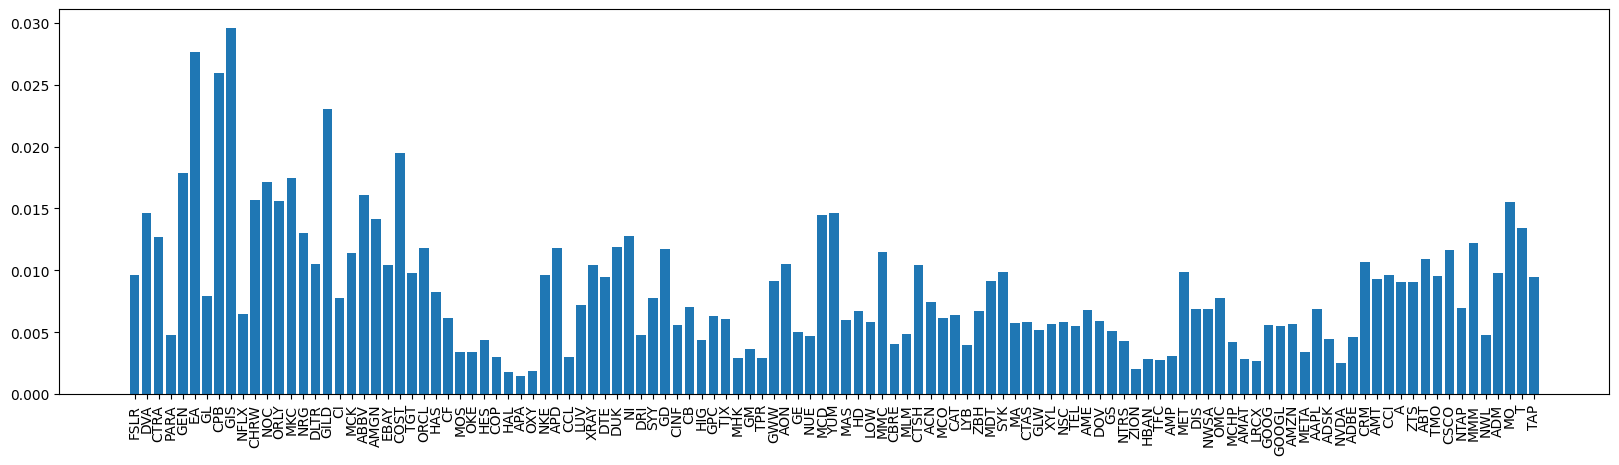

In [167]:
result = getRecBipart(retornos.cov(), cluster_members)
plt.figure(figsize=(20, 5))
plt.bar(result.index, result)
plt.xticks(rotation=90)
plt.show()

Para simplificar las cosas, definimos una función global que haga todo:

In [168]:
def hrp(retornos):
  matriz_corr = retornos.corr()
  matriz_cov = retornos.cov()
  matriz_dist = np.sqrt(0.5 * (1 - matriz_corr))
  Z = linkage(matriz_dist, "single", "euclidean")
  order = getQuasiDiag(Z)
  cluster_members = np.array(retornos.columns)[order]
  result = getRecBipart(matriz_cov, cluster_members)
  return result

<ipython-input-168-f99bb22a8728>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(matriz_dist, "single", "euclidean")


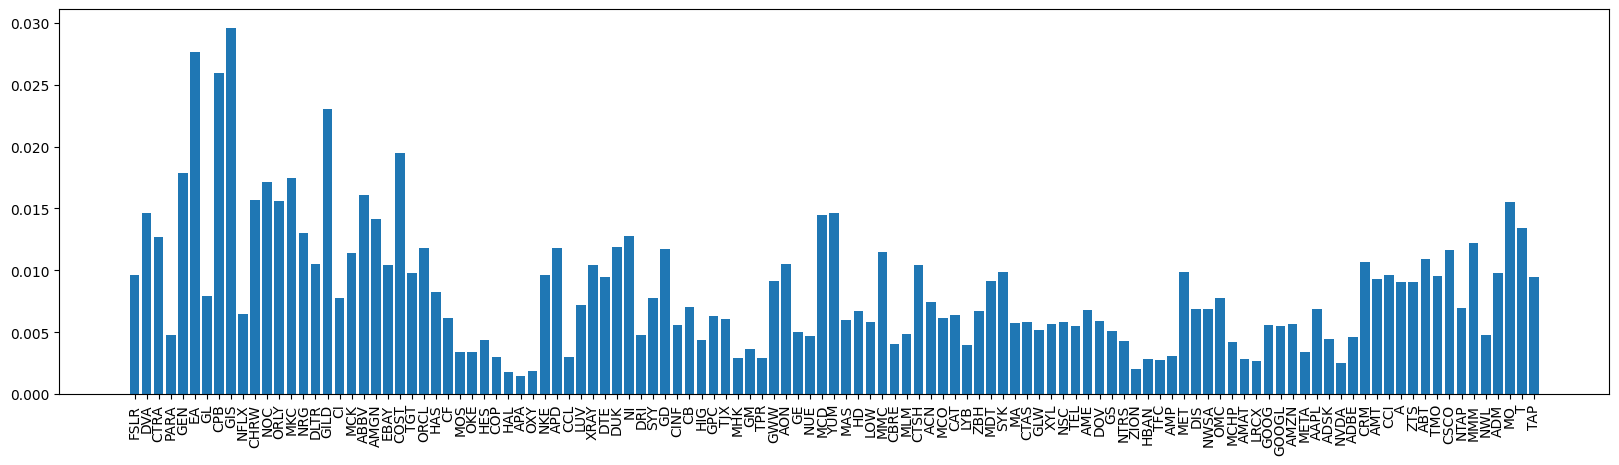

In [169]:
result = hrp(retornos)
plt.figure(figsize=(20, 5))
plt.bar(result.index, result)
plt.xticks(rotation=90)
plt.show()

# Ejercicio 1

Desarrolla un entorno de prueba donde evaluar el HRP. Por ejemplo, utiliza los datos hasta el 31 de diciembre de 2022 y evalua el ratio de Sharpe (asumiendo rf = 0) de la cartera del próximo año.

In [236]:
precios_train = yf.download(lista_activos, start="2020-01-01", end="2022-12-31")["Adj Close"]
precios_test = yf.download(lista_activos, start="2023-01-01", end="2023-12-31")["Adj Close"]

retornos_train = np.log(precios_train).diff().dropna()
retornos_test = np.log(precios_test).diff().dropna()

[*********************100%%**********************]  117 of 117 completed
[*********************100%%**********************]  117 of 117 completed


In [237]:
pesos = hrp(retornos_train)
retornos_cartera = retornos_test @ pesos
rentabilidad = retornos_cartera.mean() * 252
riesgo = retornos_cartera.std() * np.sqrt(252)
sharpe = rentabilidad / riesgo
print(sharpe)

<ipython-input-168-f99bb22a8728>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(matriz_dist, "single", "euclidean")


0.7447025043917906


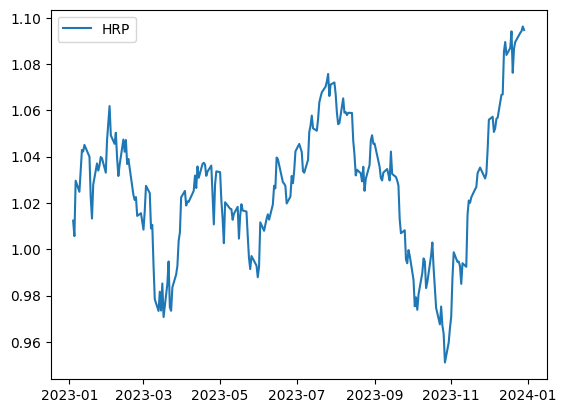

In [238]:
plt.plot(np.exp(retornos_cartera.cumsum()), label="HRP")
plt.legend()
plt.show()

# Ejercicio 2

¿Es importante utilizar la matriz de distancia propuesta por López de Prado en lugar de utilizar directamente la matriz de correlación? Modifica el algoritmo para utilizar la matriz de correlación directamente y vuelve a evaluar en el entorno de prueba que has desarrollado anteriormente.

In [239]:
def hrp_ej2(retornos):
  matriz_corr = retornos.corr()
  matriz_cov = retornos.cov()
  #matriz_dist = np.sqrt(0.5 * (1 - matriz_corr))
  Z = linkage(matriz_corr, "single", "euclidean")
  order = getQuasiDiag(Z)
  cluster_members = np.array(retornos.columns)[order]
  result = getRecBipart(matriz_cov, cluster_members)
  return result

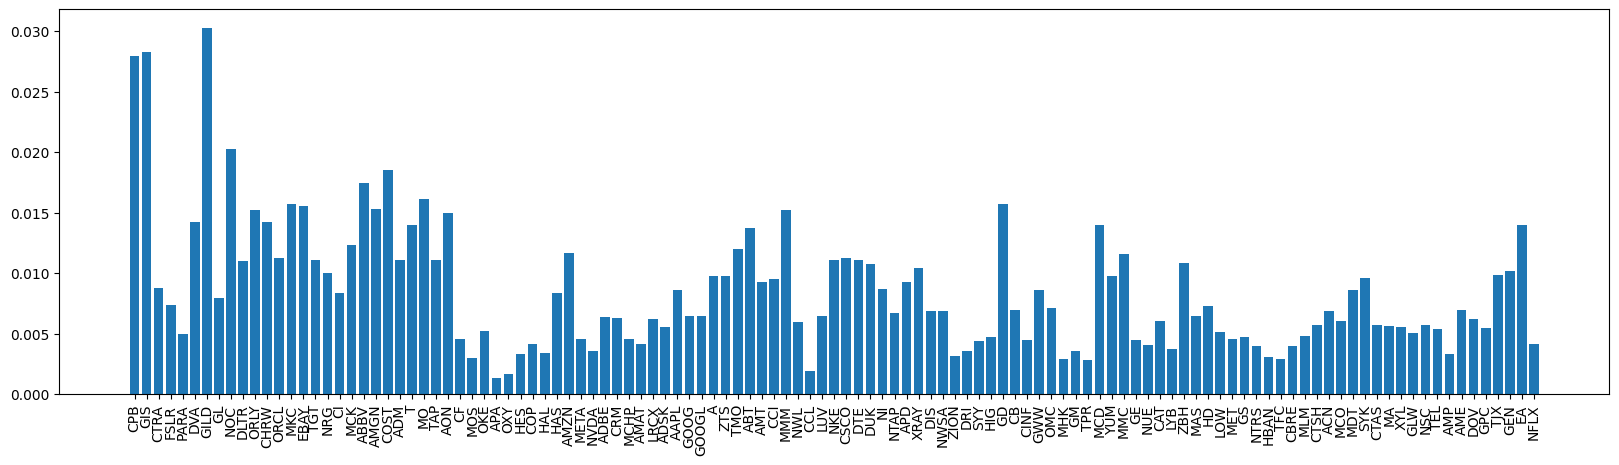

In [240]:
result = hrp_ej2(retornos)
plt.figure(figsize=(20, 5))
plt.bar(result.index, result)
plt.xticks(rotation=90)
plt.show()

In [241]:
pesos = hrp_ej2(retornos_train)
retornos_cartera_ej2 = retornos_test @ pesos
rentabilidad = retornos_cartera_ej2.mean() * 252
riesgo = retornos_cartera_ej2.std() * np.sqrt(252)
sharpe = rentabilidad / riesgo
print(sharpe)

0.777046245084488


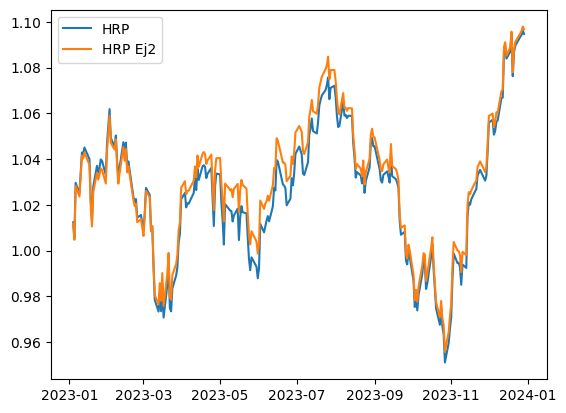

In [242]:
plt.plot(np.exp(retornos_cartera.cumsum()), label="HRP")
plt.plot(np.exp(retornos_cartera_ej2.cumsum()), label="HRP Ej2")
plt.legend()
plt.show()

# Ejercicio 3

Hemos pasado por alto el siguiente detalle. El linkage que estamos utilizando es `single` (distancia mínima). ¿Qué sucede con otros linkages?

In [243]:
def hrp_ej3(retornos, link="single"):
  matriz_corr = retornos.corr()
  matriz_cov = retornos.cov()
  matriz_dist = np.sqrt(0.5 * (1 - matriz_corr))
  Z = linkage(matriz_dist, link, "euclidean")
  order = getQuasiDiag(Z)
  cluster_members = np.array(retornos.columns)[order]
  result = getRecBipart(matriz_cov, cluster_members)
  return result

In [244]:
pesos = hrp_ej3(retornos_train, link="average")
retornos_cartera_ej3_average = retornos_test @ pesos
rentabilidad = retornos_cartera_ej3_average.mean() * 252
riesgo = retornos_cartera_ej3_average.std() * np.sqrt(252)
sharpe = rentabilidad / riesgo
print(sharpe)

<ipython-input-243-7629f28ce137>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(matriz_dist, link, "euclidean")


0.8603321702276515


In [245]:
pesos = hrp_ej3(retornos_train, link="complete")
retornos_cartera_ej3_complete = retornos_test @ pesos
rentabilidad = retornos_cartera_ej3_complete.mean() * 252
riesgo = retornos_cartera_ej3_complete.std() * np.sqrt(252)
sharpe = rentabilidad / riesgo
print(sharpe)

<ipython-input-243-7629f28ce137>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(matriz_dist, link, "euclidean")


0.7764469999996733


In [246]:
pesos = hrp_ej3(retornos_train, link="centroid")
retornos_cartera_ej3_centroid = retornos_test @ pesos
rentabilidad = retornos_cartera_ej3_centroid.mean() * 252
riesgo = retornos_cartera_ej3_centroid.std() * np.sqrt(252)
sharpe = rentabilidad / riesgo
print(sharpe)

<ipython-input-243-7629f28ce137>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(matriz_dist, link, "euclidean")


0.8324217489421513


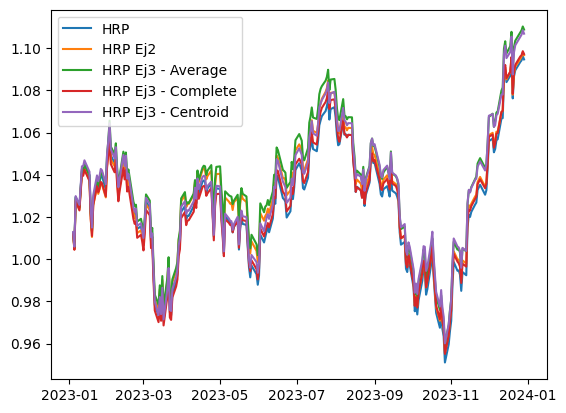

In [247]:
plt.plot(np.exp(retornos_cartera.cumsum()), label="HRP")
plt.plot(np.exp(retornos_cartera_ej2.cumsum()), label="HRP Ej2")
plt.plot(np.exp(retornos_cartera_ej3_average.cumsum()), label="HRP Ej3 - Average")
plt.plot(np.exp(retornos_cartera_ej3_complete.cumsum()), label="HRP Ej3 - Complete")
plt.plot(np.exp(retornos_cartera_ej3_centroid.cumsum()), label="HRP Ej3 - Centroid")
plt.legend()
plt.show()

# Ejercicio 4

¿Y si ideamos alguna otra manera de hacer clustering con otros algoritmos? Necesitamos definir el orden de construcción de la matriz de quasi-diagonalization. Intenta construir algo con K-Means, por ejemplo.

In [248]:
from sklearn.cluster import KMeans

In [255]:
def kmeans_pesos(retornos, K=2):
  matriz_corr = retornos.corr()
  matriz_cov = retornos.cov()
  matriz_dist = np.sqrt(0.5 * (1 - matriz_corr))
  clusters = KMeans(n_clusters=K).fit_predict(matriz_dist)
  order = []
  for c in np.unique(clusters):
    order += list(np.where(clusters == c)[0])
  cluster_members = np.array(retornos.columns)[order]
  result = getRecBipart(matriz_cov, cluster_members)
  return order, result

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


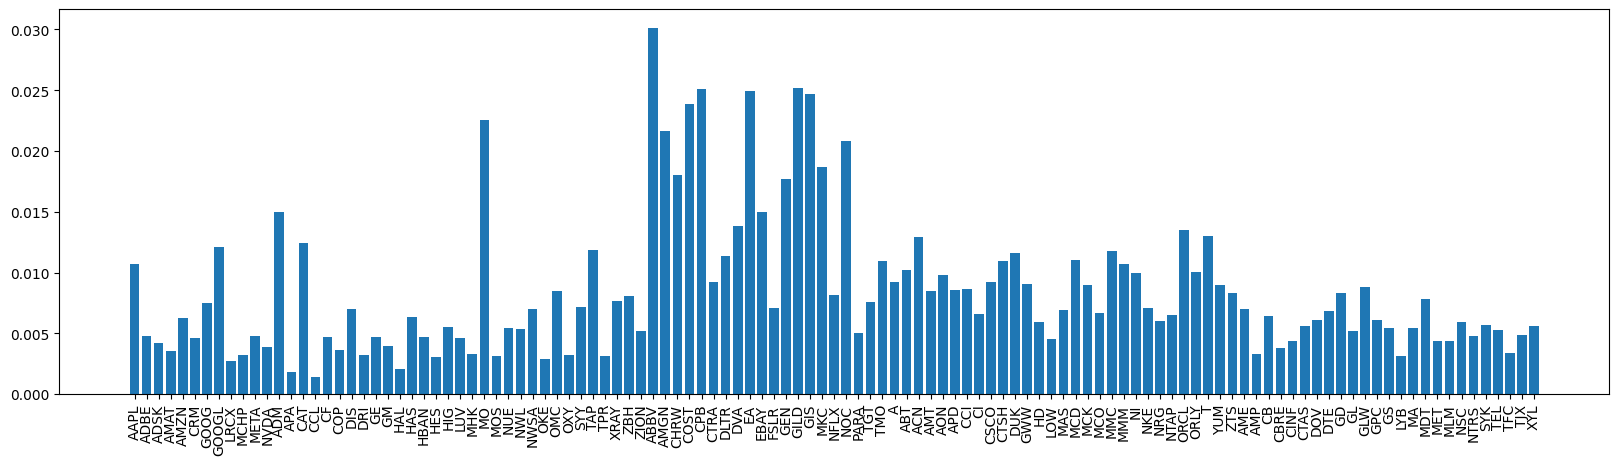

In [263]:
order, result = kmeans_pesos(retornos_train, K=5)
plt.figure(figsize=(20, 5))
plt.bar(result.index, result)
plt.xticks(rotation=90)
plt.show()

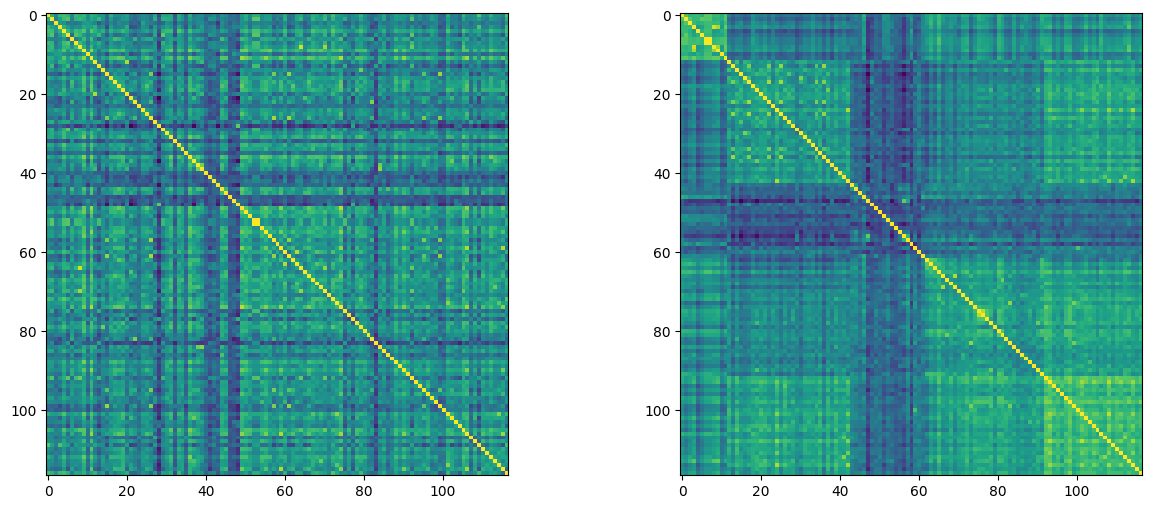

In [264]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.imshow(retornos_train.corr())
plt.subplot(1,2,2)
plt.imshow(retornos_train.corr().iloc[order, order])
plt.show()

In [267]:
_, pesos = kmeans_pesos(retornos_train, K=5)
retornos_cartera_ej4 = retornos_test @ pesos
rentabilidad = retornos_cartera_ej4.mean() * 252
riesgo = retornos_cartera_ej4.std() * np.sqrt(252)
sharpe = rentabilidad / riesgo
print(sharpe)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.8142975772667529


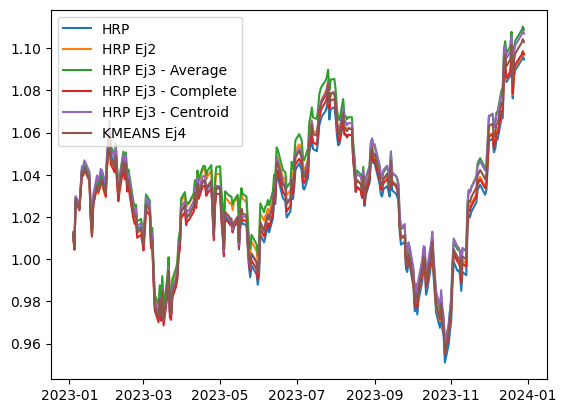

In [268]:
plt.plot(np.exp(retornos_cartera.cumsum()), label="HRP")
plt.plot(np.exp(retornos_cartera_ej2.cumsum()), label="HRP Ej2")
plt.plot(np.exp(retornos_cartera_ej3_average.cumsum()), label="HRP Ej3 - Average")
plt.plot(np.exp(retornos_cartera_ej3_complete.cumsum()), label="HRP Ej3 - Complete")
plt.plot(np.exp(retornos_cartera_ej3_centroid.cumsum()), label="HRP Ej3 - Centroid")
plt.plot(np.exp(retornos_cartera_ej4.cumsum()), label="KMEANS Ej4")
plt.legend()
plt.show()

# Ejercicio 5

¿Y si intentas hacer clustering de activos no a partir de la matriz de correlación, sino de la estrategia de clustering de activos con Momentum que vimos en el notebook anterior?

In [277]:
momentum_values = [5, 10, 20, 30, 40, 50]
lista_atributos = ["logRet"] + ["momentum@"+str(m) for m in momentum_values]

def preprocesar_activo(activo, start="2020-01-01", end="2022-12-31"):
    # Por empezar en algún valor, guardamos siempre a partir del 1 de enero de 2010
    ohlc = yf.download(tickers=activo, start=start, end=end)

    # Calculamos los retornos logarítmicos
    ohlc["logRet"] = np.log(ohlc["Adj Close"]).diff()

    # Calculamos los momentums a distintas ventanas temporales
    for momentum in momentum_values:
        ohlc["momentum@"+str(momentum)] = ohlc["logRet"].rolling(momentum).sum()

    # Limpiamos los NaN
    ohlc.dropna(inplace = True)

    # Eliminamos el resto de atributos del dataset que no nos interesan
    datos = ohlc[lista_atributos]

    # Devolvemos el resultado en formato numpy para poder trabajarlos más cómodamente
    return datos.values, ohlc

activos = lista_activos # Añadir en esta lista los activos que uno quiera.
lista_vectores = []
for activo in activos:
    dataset, _ = preprocesar_activo(activo)
    lista_vectores.append(dataset)
dataset = np.concatenate(lista_vectores, axis=0)
print(dataset.shape)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

(82602, 7)


In [278]:
means = dataset.mean(axis=0, keepdims=True)
stds = dataset.std(axis=0, keepdims=True)
dataset = (dataset - means) / stds

In [279]:
df = pd.DataFrame(dataset, columns=lista_atributos)
df.sample(5)

,logRet,momentum@5,momentum@10,momentum@20,momentum@30,momentum@40,momentum@50
21416,-0.244753,-0.794555,-0.793777,0.044886,-0.019078,0.052710,0.073133
68139,0.504507,-0.839732,-0.197099,-0.161628,-0.755338,-0.731848,-0.924671
68703,-0.541523,-0.040618,-0.315718,-0.604250,-0.233948,0.101160,0.232309
52931,-0.812176,-0.141538,-0.088258,0.126780,0.689218,1.048895,1.058860
66416,1.185873,1.283533,1.616777,1.765729,2.577460,2.099691,1.117603


In [280]:
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
kmeans.fit(dataset)

KMeans(n_clusters=12, n_init=20)

In [281]:
vectores = []
for activo in lista_activos:
  datos_test, ohlc = preprocesar_activo(activo)
  datos_test = (datos_test - means) / stds # Recuerda normalizar los datos con las medias y stds de "los datos conocidos"
  clusters_test = kmeans.predict(datos_test)

  # Contemos cuántas veces el Kmeans agrupa el activo en cada cluster a lo largo del tiempo
  vector = np.zeros(n_clusters)
  for c in clusters_test:
      vector[c] += 1

  # Deberíamos normalizar el vector para compararlo con otros activos. No es necesario ahora
  vector = vector / vector.sum()
  vectores.append(vector)
vectores = np.array(vectores)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [296]:
def hrp_ej5(retornos, vectores, link="single"):
  matriz_cov = retornos.cov()
  Z = linkage(vectores, link, "euclidean")
  order = getQuasiDiag(Z)
  cluster_members = np.array(retornos.columns)[order]
  result = getRecBipart(matriz_cov, cluster_members)
  return order, result

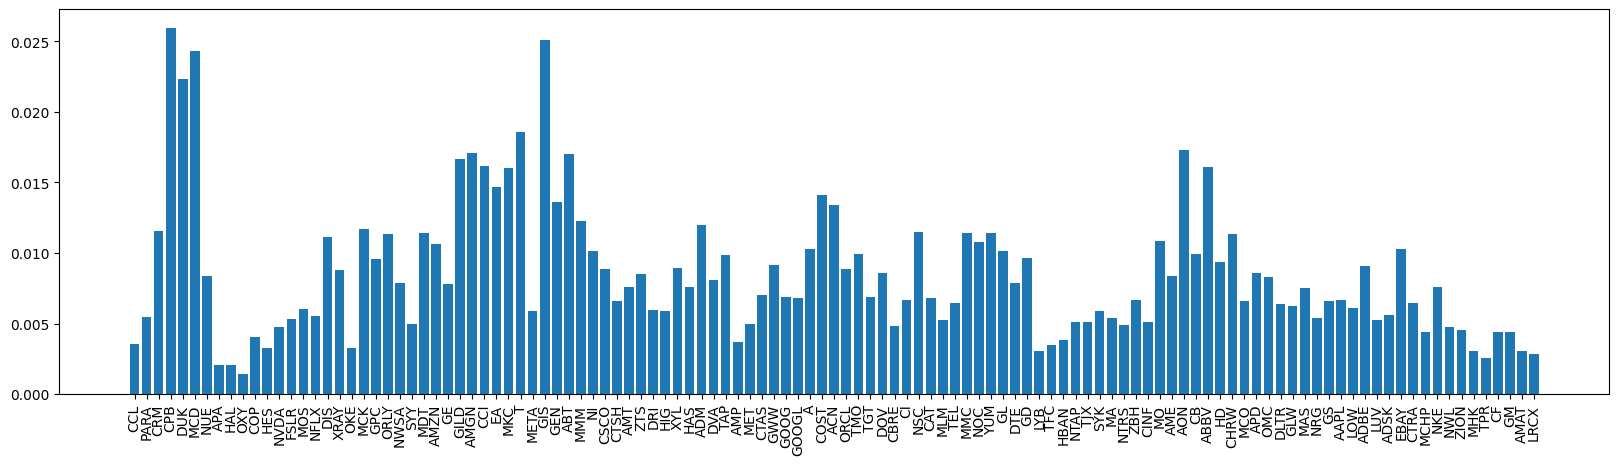

In [297]:
order, result = hrp_ej5(retornos_train, vectores)
plt.figure(figsize=(20, 5))
plt.bar(result.index, result)
plt.xticks(rotation=90)
plt.show()

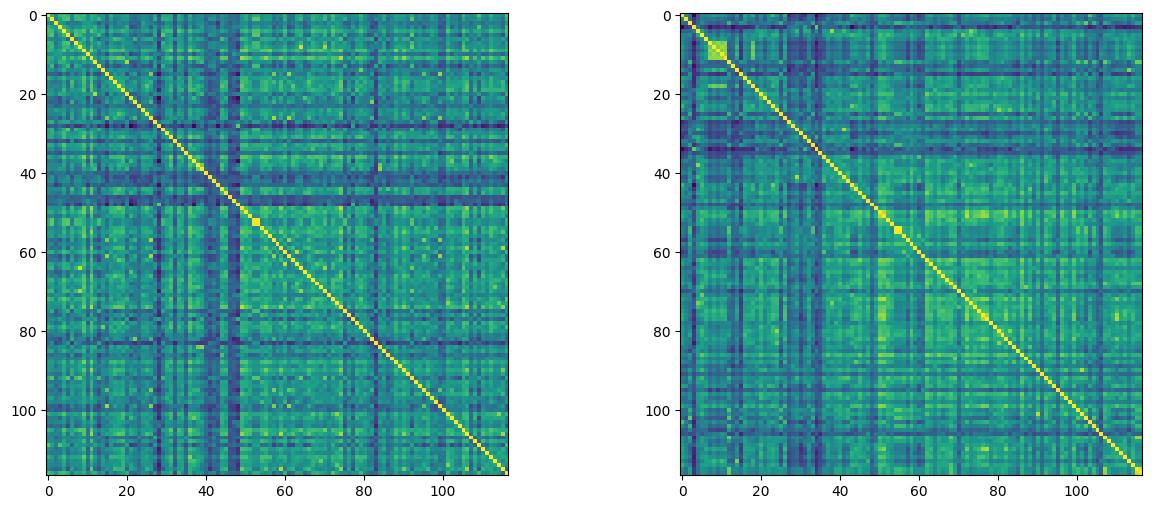

In [298]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.imshow(retornos_train.corr())
plt.subplot(1,2,2)
plt.imshow(retornos_train.corr().iloc[order, order])
plt.show()

In [285]:
pesos = hrp_ej5(retornos_train, vectores)
retornos_cartera_ej5 = retornos_test @ pesos
rentabilidad = retornos_cartera_ej5.mean() * 252
riesgo = retornos_cartera_ej5.std() * np.sqrt(252)
sharpe = rentabilidad / riesgo
print(sharpe)

0.8673823462707279


In [293]:
pesos = hrp_ej5(retornos_train, vectores, link="centroid")
retornos_cartera_ej5_centroid = retornos_test @ pesos
rentabilidad = retornos_cartera_ej5_centroid.mean() * 252
riesgo = retornos_cartera_ej5_centroid.std() * np.sqrt(252)
sharpe = rentabilidad / riesgo
print(sharpe)

0.8626786825362505


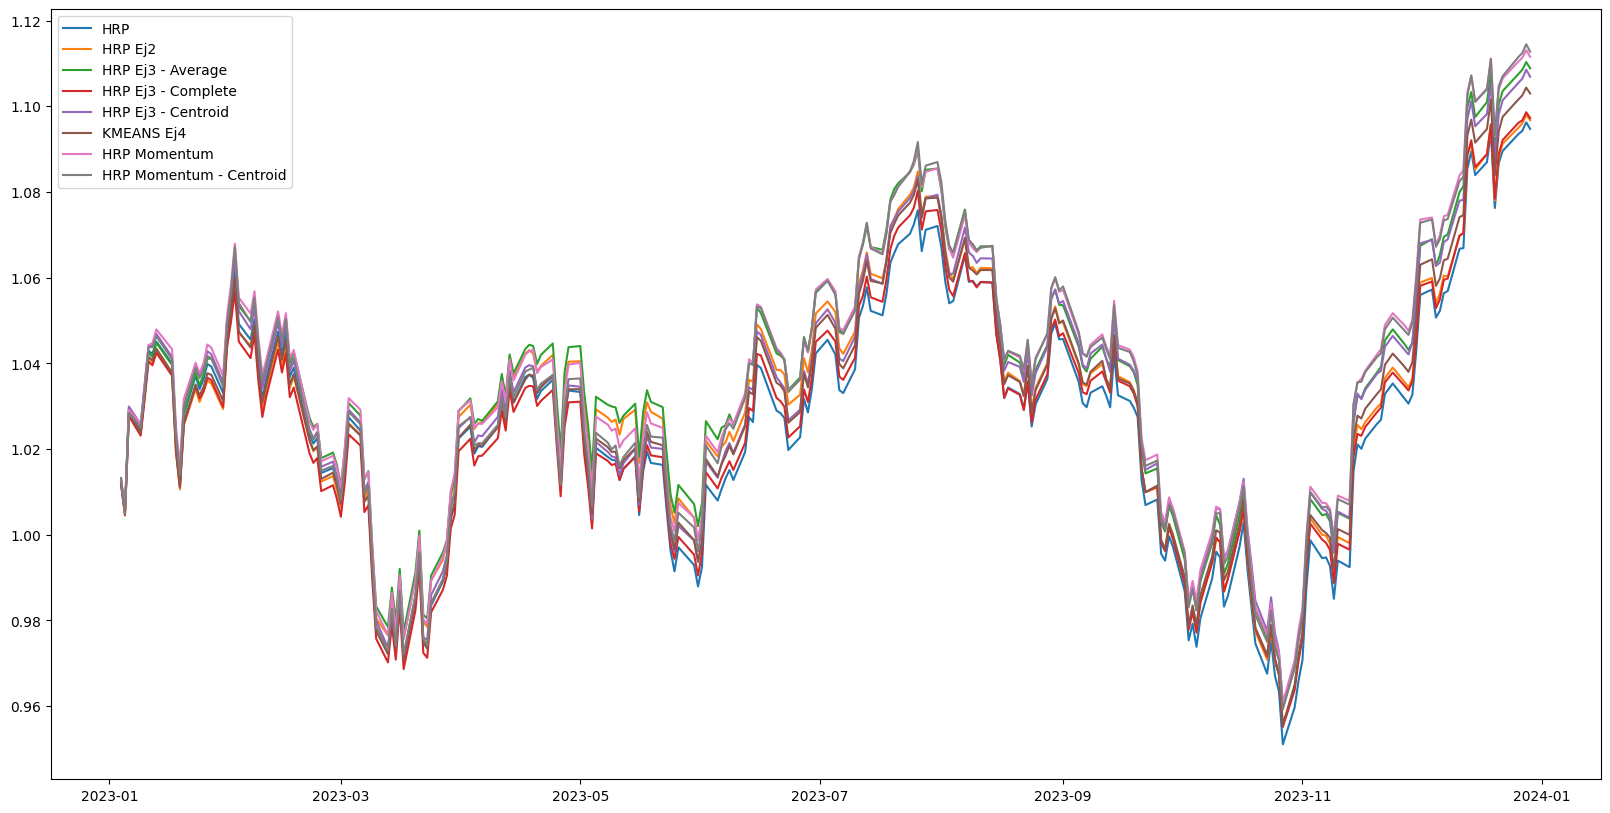

In [295]:
plt.figure(figsize=(20, 10))
plt.plot(np.exp(retornos_cartera.cumsum()), label="HRP")
plt.plot(np.exp(retornos_cartera_ej2.cumsum()), label="HRP Ej2")
plt.plot(np.exp(retornos_cartera_ej3_average.cumsum()), label="HRP Ej3 - Average")
plt.plot(np.exp(retornos_cartera_ej3_complete.cumsum()), label="HRP Ej3 - Complete")
plt.plot(np.exp(retornos_cartera_ej3_centroid.cumsum()), label="HRP Ej3 - Centroid")
plt.plot(np.exp(retornos_cartera_ej4.cumsum()), label="KMEANS Ej4")
plt.plot(np.exp(retornos_cartera_ej5.cumsum()), label="HRP Momentum")
plt.plot(np.exp(retornos_cartera_ej5_centroid.cumsum()), label="HRP Momentum - Centroid")
plt.legend()
plt.show()

# Discusión de los resultados

¿Qué sucedería si...

- tuviésemos una pre-selección de activos que consiga una buena diversificación con pocos activos? ¿Cómo podríamos avanzar?

- desarrollásemos algún mecanismo de clustering de activos que no utilice la matriz de correlación ni para clusterizar ni para splitear? ¿Podríamos tomar otro tipo de decisiones?

# Visualización con Graphext

In [300]:
matriz_corr.to_csv("datos_graphext_HRP.csv")